# Week 10 Lab


# **The Kanpsack Problem**

The knapsack problem is a classical optimisation problem thet has been studied for more than a century. The statement of the problem is as follows: Given a set of items, each with a weight and a value, collect a combination of items with the largest value, such that the weight of the sollection has to be limited by a given capacity.

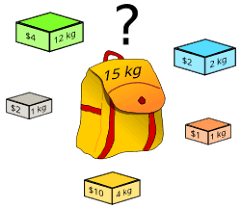

The brute force solution to this problem works by calculating the weight and value of all possible combinations and pick the combination with the maximum value and wight <= capacity. The computational complexity of this brute force solution is exponential!!
Using genetic algorithms, we can find very good solutions (near optimal) very efficiently. In this lab, we will learn how to do this.


# Problem formulation

- Gene: an item represented by weight & value
- Individual (“chromosome”): a sack including a combination of items
- Population: a collection of possible sacks (i.e., collection of individuals)
- Parents: two individuals that are combined to create a new individual
- Fitness: a function that tells us how good each individual (i.e., sack) is
- Mutation: a way to introduce variation in our population by randomly changing the inclusion of one item in a sack


# Steps

Our GA will proceed in the following steps:

1. Create the population
2. Determine fitness of each individual in the population
3. Select parents to form the mating pool for the next generation
4. Breed to get new children (individuals of next generation)
5. Mutate childern to introduce vaiations
6. Repeat steps 2-5 till the maximum number of generations is reached or till no better individuals can be produced


In [2]:
import random
import sys
import operator
import matplotlib.pyplot as plt


# an item is represented by weight & value
# This is the gene
class Item(object):
    def __init__(self, value, weight, name=""):
        self.name = name
        self.value = value
        self.weight = weight


class Knapsack(object):

    # initialize variables and lists
    def __init__(
        self,
        itemList,
        capacity,
        populationSize,
        numGenerations,
        patience=20,
        verbose=False,
    ):
        self.itemList = itemList
        self.capacity = capacity
        self.populationSize = populationSize
        self.verbose = verbose

        self.population = []
        self.fitness = []
        self.parents = []
        self.numGenerations = numGenerations
        self.patience = patience
        self.patienceCounter = 0
        self.bestFitness = -1000000
        self.bestfoundAt = -1
        self.bestIndividual = None
        self.listOfBestFitness = []

        self.initialisePopulation()
        print("finished intitialisation")

    # Step number 1: create the individuals in the initial population
    def initialisePopulation(self):
        for i in range(self.populationSize):
            individual = []
            for k in range(0, len(self.itemList)):
                k = random.randint(0, 1)
                individual.append(k)
            self.population.append(individual)

    # Step 2: calculate fittness
    def evaluation(self, generationNumber):
        # loop through individuals and calculate fitness
        for i in range(len(self.population)):
            ft = self.calcFitness(self.population[i])
            self.fitness.append((ft, self.population[i]))

        # sort the fitness list by fitness
        self.fitness.sort(key=operator.itemgetter(0), reverse=True)
        if self.fitness[0][0] > self.bestFitness:
            self.bestFitness = self.fitness[0][0]
            self.bestIndividual = self.fitness[0][1]
            self.bestfoundAt = generationNumber
            self.patienceCounter = 0

    # Step 2 continued - calculate the fitness of a given individual (sack)
    def calcFitness(self, sack):
        # print(sack)
        sum_w = 0  # sum of weights of items in the sack
        sum_v = 0  # sum of values of items in the sack

        # calculate sum of weights and values
        for i in range(len(sack)):
            sum_w += sack[i] * self.itemList[i].weight
            sum_v += sack[i] * self.itemList[i].value

        if sum_w > self.capacity:  # --> not valid solution so retun fitness of -1
            return -1
        else:  # fitness = sum of item values in the sack
            return sum_v

        # Step 3 select parents to form the mating pool

    def selectParents(self):
        numElites = self.populationSize // 4
        numParents = numElites * 2
        self.parents = [x[1] for x in self.fitness[:numElites]]
        otherParentsIndecies = random.sample(
            range(numElites, numParents), numParents - numElites
        )
        for i in otherParentsIndecies:
            self.parents.append(self.fitness[i][1])

    # Step 4 breeding via crossover of two parents to produce two children
    def crossover(self, sack1, sack2):
        threshold = random.randint(0, len(sack1))
        tmp1 = sack1[threshold:]
        tmp2 = sack2[threshold:]
        sack1 = sack1[:threshold]
        sack2 = sack2[:threshold]
        sack1.extend(tmp2)
        sack2.extend(tmp1)

        return sack1, sack2

    # Step 5 mutate child
    def mutation(self, sack):
        for i in range(len(sack)):
            k = random.uniform(0, 1)
            if k > 0.8:
                if sack[i] == 1:
                    sack[i] = 0
                else:
                    sack[i] = 1
        return sack

    # run all the steps of the GA algorithms for a given numGenerations
    def run(self):

        for g in range(self.numGenerations):
            self.evaluation(g)
            self.selectParents()
            newPopulation = []

            for i in range(self.populationSize):
                [parent1Indx, parent2Indx] = random.sample(
                    range(0, len(self.parents)), 2
                )
                child1, child2 = self.crossover(
                    self.parents[parent1Indx], self.parents[parent2Indx]
                )
                newPopulation.append(child1)
                newPopulation.append(child2)

            # mutate the new children
            for i in range(len(newPopulation)):
                newPopulation[i] = self.mutation(newPopulation[i])
            self.patienceCounter += 1
            self.listOfBestFitness.append(self.bestFitness)
            if self.patienceCounter == self.patience:
                print("Stopped after {} generations".format(g))
                break

            else:
                if g % 10 == 0 and self.verbose:
                    print(
                        "Generation {} Best fitness so far {} ; found at generation {}".format(
                            g, self.bestFitness, self.bestfoundAt
                        )
                    )

                self.population = newPopulation
                self.fitness = []
                self.parents = []
        print(
            "Best individual is {} ; fitness value is {} ; found at generation {}".format(
                self.bestIndividual, self.bestFitness, self.bestfoundAt
            )
        )

In [3]:
# function to test knapsack optimisation using a given sets of parameters
def optimiseKnapsack(
    numAvailableItems,
    capacity,
    maxWeightPerItem,
    maxValuePerItem,
    populationSize,
    numGenerations,
    patience=500,
    verbose=False,
):
    itemList = []
    for i in range(numAvailableItems):
        itemList.append(
            Item(
                random.randint(1, maxWeightPerItem), random.randint(1, maxValuePerItem)
            )
        )

    print("Available Items:")
    print("weights " + str([x.weight for x in itemList]))
    print("values " + str([x.value for x in itemList]))

    k = Knapsack(
        itemList, capacity, populationSize, numGenerations, patience, verbose=verbose
    )
    k.run()
    plt.plot(k.listOfBestFitness)
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title("Best Fitness over Generations")
    plt.show()

# Test the GA algorithm on knapsack problems with different parameters


Valid solution have fitness>0 such that fitness increases with object value. Invalid solutions have a fitnees < 0.


Available Items:
weights [8, 5, 4, 4, 2, 8, 8, 1, 9, 10, 9, 9, 1, 4, 5, 3, 5, 1, 10, 6, 3, 3, 10, 3, 10, 4, 5, 9, 10, 6, 7, 8, 5, 1, 2, 10, 1, 9, 7, 4, 9, 1, 9, 2, 1, 5, 1, 2, 2, 5]
values [14, 2, 1, 8, 5, 19, 13, 8, 5, 19, 2, 16, 7, 17, 16, 18, 2, 19, 2, 8, 7, 16, 12, 5, 4, 19, 20, 20, 14, 4, 19, 7, 4, 20, 19, 17, 14, 11, 8, 3, 16, 16, 6, 18, 5, 11, 16, 6, 9, 10]
finished intitialisation
Stopped after 802 generations
Best individual is [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0] ; fitness value is 205 ; found at generation 303


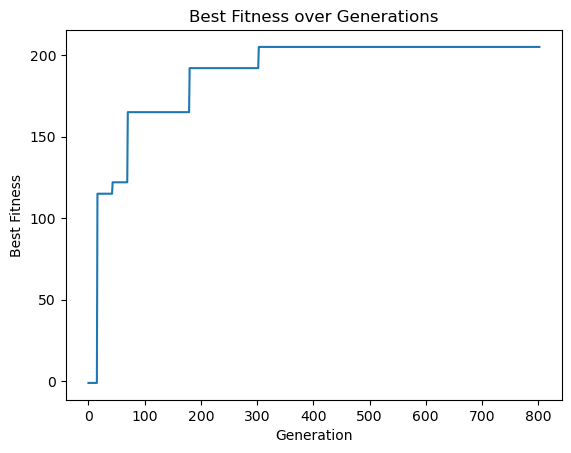

In [4]:
# parameters related to the knapsack problem itself regardless of the algorithm used for solving it
numAvailableItems = 50
capacity = 50
maxWeightPerItem = 20
maxValuePerItem = 10


# parameters related to the GA algorithm
populationSize = 500
numGenerations = 1000
patience = 500  # determines condition for early stopping if no better individuals are found for a specific number of iterations

optimiseKnapsack(
    numAvailableItems,
    capacity,
    maxWeightPerItem,
    maxValuePerItem,
    populationSize,
    numGenerations,
    patience=patience,
    verbose=False,
)

# Lab Tasks


1.  Make a slight change the parameters of the knapsack problem one at a time and run the GA to find a solution. Notice the effect on the diffulty of finding a solution.
2.  Is our GA algorithm still able to find a valid solution for difficult problems.
3.  What parameters have the most impact?


In [ ]:
# to do : change the parameters of the knapsack problem one at a time and run the GA to find a solution. Notice the effect on the diffulty of finding a solution
#

4.  Can changing the parameters of the GA algorithms enable finding a valid solution?


In [ ]:
# to do :

# change the parameters of the GA algorithm
# test again to see if we can get a valid solution

5. Use the original parameters given and set capacity = 35. Can you find any valid solution? Can we change the fitness function to help find any better solutions?? Discuss with your tutor if you are not sure.
